<a href="https://colab.research.google.com/github/zolfaShefreie/MCI-Chatbot/blob/main/persian_jasper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#install packages

In [2]:
!apt-get update && apt-get install -y libsndfile1 ffmpeg
!pip install Cython
!pip install nemo_toolkit[all]
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'r1.11.0'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

## Grab the config we'll use in this example
!mkdir configs
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [913 kB]
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 20 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive

In [3]:
!apt-get install libsox-fmt-mp3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libid3tag0 libmad0
The following NEW packages will be installed:
  libid3tag0 libmad0 libsox-fmt-mp3
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 112 kB of archives.
After this operation, 370 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libid3tag0 amd64 0.15.1b-13 [31.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libmad0 amd64 0.15.1b-9ubuntu18.04.1 [64.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libsox-fmt-mp3 amd64 14.4.2-3ubuntu0.18.04.1 [15.9 kB]
Fetched 112 kB in 0s (273 kB/s)
Selecting previously unselected package libid3tag0:amd64.
(Reading database ..

In [4]:
!pip install parsivar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.2 MB 444 kB/s 
     |████████████████████████████████| 1.5 MB 55.3 MB/s 
  Created wheel for parsivar: filename=parsivar-0.2.3-py3-none-any.whl size=36492972 sha256=281fe5e3bf537d7be1cba4ade929c9d6081b083aebb8dd0e16a2294fb58934bf
  Stored in directory: /root/.cache/pip/wheels/ae/67/7a/49cbf08f64d3f76a26eceaf0e481a40e233f05d4356875cbed
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449924 sha256=20eeaabc53bf0d0de543370e65a411997e22d0cf609d3bc595ded016f0ec37c6
  Stored in directory: /root/.cache/pip/wheels/48/8b/7f/473521e0c731c6566d631b281f323842bbda9bd819eb9a3ead
Successfully built parsivar nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


#imports

In [5]:
import glob
import os
import subprocess
import tarfile
import wget
import copy
import nemo.collections.asr as nemo_asr
from omegaconf import OmegaConf, open_dict
import torch
import pytorch_lightning as ptl
from pytorch_lightning.callbacks import ModelCheckpoint
import shutil
from tqdm.auto import tqdm
import json
from parsivar import Normalizer

[NeMo W 2022-09-28 06:18:12 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


#Load CommonVoice Dataset
nemo has [script](https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/dataset_processing/get_commonvoice_data.py) for loading commonVoice dataset

In [6]:
data_dir = '/content/drive/MyDrive/mci/datasets/'

if not os.path.exists(data_dir):
  os.makedirs(data_dir, exist_ok=True)

if not os.path.exists("scripts"):
  os.makedirs("scripts")

In [7]:
if not os.path.exists("scripts/get_commonvoice_data.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/dataset_processing/get_commonvoice_data.py

--2022-09-28 06:18:15--  https://raw.githubusercontent.com/NVIDIA/NeMo/r1.11.0/scripts/dataset_processing/get_commonvoice_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8357 (8.2K) [text/plain]
Saving to: ‘scripts/get_commonvoice_data.py’

get_commonvoice_dat 100%[===================>]   8.16K  --.-KB/s    in 0s      

2022-09-28 06:18:15 (100 MB/s) - ‘scripts/get_commonvoice_data.py’ saved [8357/8357]



you can get the link of dataset from [here](https://commonvoice.mozilla.org/en/datasets) and choose the language of dataset.</br>
enter your email and copy link address from <b>Download</b> button. make sure to delete unnecessary part from copied link.
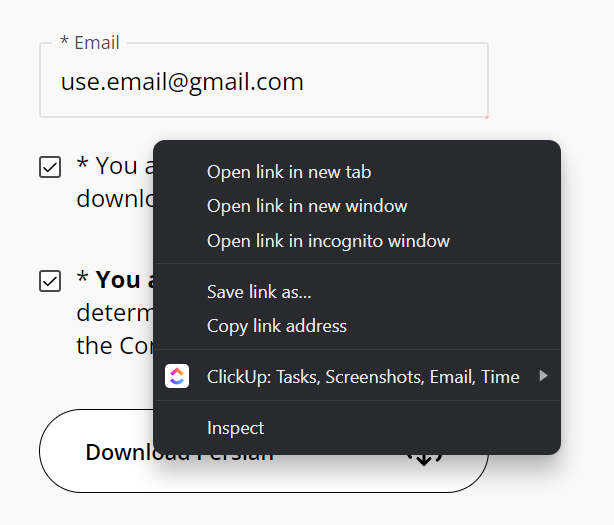

the url is https://mozilla-common-voice-datasets.s3.dualstack.us-west-2.amazonaws.com/cv-corpus-10.0-2022-07-04/cv-corpus-10.0-2022-07-04-fa.tar.gz that shows the vesion is cv-corpus-10.0-2022-07-04 and the language is fa. but the current version of nemo scrip doesn't support this version of common voice dataset so i use the default dataset version

In [8]:
VERSION = "cv-corpus-6.1-2020-12-11"
LANGUAGE = "fa"

In [9]:
tokenizer_dir = os.path.join('/content/drive/MyDrive/mci/tokenizers', LANGUAGE)
manifest_dir = os.path.join('/content/drive/MyDrive/mci/manifests', LANGUAGE)
tokenizer_dir, manifest_dir

('/content/drive/MyDrive/mci/tokenizers/fa',
 '/content/drive/MyDrive/mci/manifests/fa')

In [ ]:
# !rm -rf datasets/$LANGUAGE

In [ ]:
!python scripts/get_commonvoice_data.py \
    --data_root "datasets/$LANGUAGE/" \
    --manifest_dir=$manifest_dir \
    --sample_rate=16000 \
    --n_channels=1 \
    --version=$VERSION \
    --language=$LANGUAGE \
    --files_to_process 'train.tsv' 'dev.tsv' 'test.tsv'

--2022-09-25 08:02:09--  https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-6.1-2020-12-11/fa.tar.gz
Resolving voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com (voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com)... 52.92.196.233
Connecting to voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com (voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com)|52.92.196.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8884585819 (8.3G) [application/octet-stream]
Saving to: ‘datasets/fa/fa.tar.gz’

datasets/fa/fa.tar. 100%[===================>]   8.27G  33.1MB/s    in 4m 17s  

2022-09-25 08:06:26 (33.0 MB/s) - ‘datasets/fa/fa.tar.gz’ saved [8884585819/8884585819]

100% 7592/7592 [07:58<00:00, 15.88it/s]
100% 7592/7592 [00:00<00:00, 71288.04it/s]
100% 5212/5212 [05:39<00:00, 15.35it/s]
100% 5212/5212 [00:00<00:00, 63927.13it/

In [10]:
train_manifest = f"{manifest_dir}/commonvoice_train_manifest.json"
dev_manifest = f"{manifest_dir}/commonvoice_dev_manifest.json"
test_manifest = f"{manifest_dir}/commonvoice_test_manifest.json"

In [11]:


def read_manifest(path) -> list:
    manifest = []
    with open(path, 'r') as f:
        for line in tqdm(f, desc="Reading manifest data"):
            line = line.replace("\n", "")
            data = json.loads(line)
            manifest.append(data)
    return manifest


def change_addresses(data_dir=data_dir, language=LANGUAGE, 
                     manifest_dir=manifest_dir, old_dir="datasets"):
    """
    change address of wav files:
      copy them to data_dir and change manofest files
    """
    try:

      for each in ['train', 'test', 'dev']:

        # copy files to new dir
        src = f"{old_dir}/{language}/{each}/wav"
        dst = f"{data_dir}{language}/{each}/wav"
        if not os.path.exists(dst):
            os.makedirs(dst, exist_ok=True)
        
        src_files = os.listdir(src)
        for file_name in src_files:
            full_file_name = os.path.join(src, file_name)
            if os.path.isfile(full_file_name) and not os.path.exists(os.path.join(dst, file_name)):
                shutil.copy(full_file_name, dst)

        #change manifest files
        manifest_path = f"{manifest_dir}/commonvoice_{each}_manifest.json"
        manifest_data = read_manifest(manifest_path)
        os.remove(manifest_path)

        with open(manifest_path, 'w') as f:
          for each in manifest_data:
              file_name = each['audio_filepath'].split('/')[-1]
              each['audio_filepath'] = f"{dst}/{file_name}"
              json_each = json.dumps(each)
              f.write(f"{json_each}\n")

    except Exception as e:
      print(e)


In [12]:
if os.path.exists(f"datasets/{LANGUAGE}"):
    change_addresses()

#analyse and preprocess dataset

In [12]:
def write_processed_manifest(data, original_path):
    original_manifest_name = os.path.basename(original_path)
    new_manifest_name = original_manifest_name.replace(".json", "_processed.json")

    manifest_dir = os.path.split(original_path)[0]
    filepath = os.path.join(manifest_dir, new_manifest_name)
    with open(filepath, 'w') as f:
        for datum in tqdm(data, desc="Writing manifest data"):
            datum = json.dumps(datum)
            f.write(f"{datum}\n")
    print(f"Finished writing manifest: {filepath}")
    return filepath

In [13]:
train_manifest_data = read_manifest(train_manifest)
dev_manifest_data = read_manifest(dev_manifest)
test_manifest_data = read_manifest(test_manifest)

Reading manifest data: 0it [00:00, ?it/s]

Reading manifest data: 0it [00:00, ?it/s]

Reading manifest data: 0it [00:00, ?it/s]

In [14]:
print(f"record number of train dataset: {len(train_manifest_data)}")
print(f"record number of dev dataset: {len(dev_manifest_data)}")
print(f"record number of test dataset: {len(test_manifest_data)}")

record number of train dataset: 7592
record number of dev dataset: 5212
record number of test dataset: 5212


In [15]:
train_text = [data['text'] for data in train_manifest_data]
dev_text = [data['text'] for data in dev_manifest_data]
test_text = [data['text'] for data in test_manifest_data]

In [16]:
train_chars = set([char for text in train_text for char in text])
dev_chars = set([char for text in dev_text for char in text])
test_chars = set([char for text in test_text for char in text])
print(f" train characters: {train_chars}\n dev characters: {dev_chars}\n test characters: {test_chars}")
print(set(list(train_chars)+list(dev_chars)+list(test_chars)))

 train characters: {'–', ',', 'ض', 'ا', 'ت', '؟', 'ٌ', 'َ', 'ل', 'ق', 'ظ', 'ّ', '»', 's', 'ِ', '!', '«', 'ـ', 'c', '…', 'ژ', 'ā', 'پ', 'ً', 'b', 'ی', ':', 'ة', 'ح', 't', 'ف', 'ي', 'f', 'چ', 'د', 'ک', 'e', '.', 'š', ';', 'm', 'ش', 'ج', 'ذ', 'أ', 'م', 'ص', 'y', 'ر', '(', '-', 'ؤ', 'ى', '؛', 'ب', 'غ', 'و', 'n', '٬', 'a', 'ث', 'ٔ', 'r', 'ز', 'ه', 'ن', '"', 'ئ', 'گ', 'i', '،', 'خ', 'ء', 'ك', 'ُ', ')', 'س', ' ', 'ے', 'ۀ', 'ْ', 'ع', 'ط', 'آ'}
 dev characters: {'–', 'ﻮ', ',', 'ض', 'ﻢ', 'ا', 'ت', '؟', 'ﮐ', 'ﻌ', 'َ', 'ل', 'ظ', 'ق', 'ّ', '»', 's', 'ِ', '!', '«', 'p', 'ـ', 'c', 'ﺎ', '…', 'ژ', 'ﺱ', 'ﯽ', 'پ', 'ً', 'b', 'ی', ':', 'ح', 'ﻟ', 'ﻡ', 'ف', 'ي', 'f', 'ﺑ', 'چ', 'ﭘ', 'd', 'د', 'ک', '.', '#', 'ﻀ', 'ش', 'ج', 'ذ', 'أ', 'م', 'ص', 'ر', '-', '(', 'z', 'ﺧ', 'ؤ', 'ى', '؛', 'ب', 'غ', 'و', '٬', 'ﺩ', 'a', 'ث', 'ٔ', 'ز', 'ه', 'ن', '"', 'ئ', 'گ', 'i', '،', 'خ', 'ء', 'ﺘ', 'ك', 'ﻪ', 'ُ', ')', 'س', ' ', 'ﺍ', 'ع', 'ط', 'آ'}
 test characters: {'k', 'ﻮ', ',', 'g', 'ض', 'ﻢ', 'q', 'ا', 'ت', '؟', 'ﮐ', 'ﻌ', 'ﻭ', 'ﺷ'

In [ ]:
for text in train_text:
  for char in 'ﯽےﯾيﯿ':
    if char in text:
       print(text)

خیلی زود کثیف مىشود و تحت تأثير رطوبت و نور قرار مىگيرد
زن بدكاره زنا میكند و با بیشرمی میگويد گناهی نكردهام
از بانك وام بگيرن پول رو به خودروساز نقدى بدن و اقساط رو به بانك پرداخت كنن
خوب زاک آدم خوبيه نه؟
ببين ، خودت که ميدوني
اون دختره خوشکله ميزدم
جدي تو يه انترن هستي ؟
می توانید قد آستين من را اندازه بگیرید؟
مرد ها باید یاد بگیرند گاهی خستگی را با چاي از تن همسرشان درآورند
و معمولا روى بوم صورت مىگيرد
صحيفههاى ابراهيم و موسى
تاريخچه اين نوع نقاشی در ايران به عهد صفويان باز مىگردد
ژل لوبريكانت روان كننده بي ضرر براي نزديكي بهتر
آبریزش بيني دارم.
عبور كشتی از دريا
هستند كسانی كه پدر و مادر خود را نفرين میكنند
لطفاً انتهای مو را به داخل فر کنيد.
آن كس كه ترسد، بزودى عبرت گيرد
من بدم میآيد کراوات بزنم.
آيا شنبه باز هستید؟
چهار چيز برای من بسيار عجيبند و من آنها را نمیفهمم
خداى رحمان كه بر عرش استيلا يافته است
هم بى اراده هم بيكاره، هم بى انصافه هم بى ذاته
مريم گفت: اگر پرهيزگارى، من از تو به خداى رحمان پناه مىبرم
به آنچه او گفت توجه نکنيد.
پس از پايان کار بايد از فيکساتیو استفاده کرد


In [17]:
replce_char = {'ﭘ':'پ',
                'ﺸ': 'ش',
                'ﻧ': 'ن',
                'ﮔ': 'گ',
                'آآﺎأ': 'ا',
                'ﻟ': 'ل',
                'ﺧ': 'خ',
                'ﻌﻋﻋﻌ': 'ع', 
                'ﺘ': 'ت', 
                'ﺴ': 'س',
                'ﻪ': 'ه', 
                'ﺑ': 'ب', 
                'ﯽےﯾيﯿ': 'ی',
                'كﮐ': 'ک',
                'ﺷ': 'ش',
                'ﻀ': 'ض',
                'ﺒ':'ب',
                'ﻤ': 'م'}
unvalid_char = '!~‍‍@#$.,/\])(*&^%$["' + "'«»[]-_=+}{…؛‌،-ـ;٬–:?؟"

SPLITTION = 0.3 #use less data for train and test
FNormalizer = Normalizer()

def preprocess(data):
  text = data['text']
  text = FNormalizer.normalize(text)
  text = text.replace("‌", "")
  
  for key, value in replce_char.items():
    if set(key).intersection(set(text)):
       common = set(key).intersection(set(text))
       for each in common:
         text = text.replace(each, value)

  for each in unvalid_char:
    text = text.replace(each, '')
  data['text'] = text
  return data


def apply_preprocessors(manifest, process_func=preprocess, splition=SPLITTION):
    counter = 0
    max_num = int(len(manifest)*splition)
    for idx in tqdm(range(max_num), desc=f"Applying {process_func.__name__}"):
        if counter > max_num:
          break
        manifest[idx] = process_func(manifest[idx])
        counter+=1
    return manifest

In [18]:
data = {'text': 'به سرکار رآس نگاه می کنيد'}
preprocess(data)

{'text': 'به سرکار راس نگاه میکنید'}

In [19]:
# Load manifests
train_data = read_manifest(train_manifest)
dev_data = read_manifest(dev_manifest)
test_data = read_manifest(test_manifest)

# Apply preprocessing
train_data_processed = apply_preprocessors(train_data)
dev_data_processed = apply_preprocessors(dev_data)
test_data_processed = apply_preprocessors(test_data)

# Write new manifests
train_manifest_cleaned = write_processed_manifest(train_data_processed, train_manifest)
dev_manifest_cleaned = write_processed_manifest(dev_data_processed, dev_manifest)
test_manifest_cleaned = write_processed_manifest(test_data_processed, test_manifest)

Reading manifest data: 0it [00:00, ?it/s]

Reading manifest data: 0it [00:00, ?it/s]

Reading manifest data: 0it [00:00, ?it/s]

Applying preprocess:   0%|          | 0/2277 [00:00<?, ?it/s]

Applying preprocess:   0%|          | 0/1563 [00:00<?, ?it/s]

Applying preprocess:   0%|          | 0/1563 [00:00<?, ?it/s]

Writing manifest data:   0%|          | 0/7592 [00:00<?, ?it/s]

Finished writing manifest: /content/drive/MyDrive/mci/manifests/fa/commonvoice_train_manifest_processed.json


Writing manifest data:   0%|          | 0/5212 [00:00<?, ?it/s]

Finished writing manifest: /content/drive/MyDrive/mci/manifests/fa/commonvoice_dev_manifest_processed.json


Writing manifest data:   0%|          | 0/5212 [00:00<?, ?it/s]

Finished writing manifest: /content/drive/MyDrive/mci/manifests/fa/commonvoice_test_manifest_processed.json


In [20]:
DATASET_FINAL_CHARS = set(list(train_chars)+list(dev_chars)) - set(''.join([each for each in replce_char.keys()])) - set(unvalid_char)
print(DATASET_FINAL_CHARS)

{'ِ', 'p', 'm', 'c', 'ئ', 'ژ', 'ﺱ', 'ش', 'گ', 'i', 'ۀ', 'ج', 'ذ', 'ā', 'خ', 'ء', 'پ', 'ﻮ', 'ً', 'b', 'م', 'ص', 'y', 'ر', 'ض', 'z', 'ی', 'ُ', 'ﻢ', 'ؤ', 'ة', 'ح', 'ى', 'ا', 'س', 'ت', 'ﻡ', 't', 'ب', 'ف', 'غ', 'و', 'f', 'ٌ', 'n', ' ', 'َ', 'ل', 'ﺩ', 'چ', 'a', 'ّ', 'ظ', 'ق', 'ث', 'd', 'ْ', 'ﺍ', 'د', 'ک', 'e', 'ٔ', 'r', 'ع', 'ز', 'ه', 'ط', 'š', 'ن', 's'}


#Fine-tunning Japster Model

In [ ]:
nemo_asr.models.EncDecCTCModel.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=QuartzNet15x5Base-En,
 	description=QuartzNet15x5 model trained on six datasets: LibriSpeech, Mozilla Common Voice (validated clips from en_1488h_2019-12-10), WSJ, Fisher, Switchboard, and NSC Singapore English. It was trained with Apex/Amp optimization level O1 for 600 epochs. The model achieves a WER of 3.79% on LibriSpeech dev-clean, and a WER of 10.05% on dev-other. Please visit https://ngc.nvidia.com/catalog/models/nvidia:nemospeechmodels for further details.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo
 ), PretrainedModelInfo(
 	pretrained_model_name=stt_en_quartznet15x5,
 	description=For details about this model, please visit https://ngc.nvidia.com/catalog/models/nvidia:nemo:stt_en_quartznet15x5,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_quartznet15x5/versions/1.0.0rc1/files/stt_en_quartznet15x5.nemo
 ), PretrainedModelInfo(
 	pretr

In [21]:
model = nemo_asr.models.ASRModel.from_pretrained("stt_en_jasper10x5dr", map_location='cpu')

[NeMo I 2022-09-28 06:18:20 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_jasper10x5dr/versions/1.0.0rc1/files/stt_en_jasper10x5dr.nemo to /root/.cache/torch/NeMo/NeMo_1.11.0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo
[NeMo I 2022-09-28 06:18:48 common:910] Instantiating model from pre-trained checkpoint


[NeMo W 2022-09-28 06:18:59 modelPT:143] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    
[NeMo W 2022-09-28 06:18:59 modelPT:150] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /data2/vo

[NeMo I 2022-09-28 06:18:59 features:223] PADDING: 16
[NeMo I 2022-09-28 06:19:06 audio_preprocessing:491] Numba CUDA SpecAugment kernel is being used
[NeMo I 2022-09-28 06:19:07 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.11.0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo.


In [22]:
model.change_vocabulary(new_vocabulary=list(DATASET_FINAL_CHARS))

[NeMo I 2022-09-28 06:19:08 ctc_models:293] Changed decoder to output to ['ِ', 'p', 'm', 'c', 'ئ', 'ژ', 'ﺱ', 'ش', 'گ', 'i', 'ۀ', 'ج', 'ذ', 'ā', 'خ', 'ء', 'پ', 'ﻮ', 'ً', 'b', 'م', 'ص', 'y', 'ر', 'ض', 'z', 'ی', 'ُ', 'ﻢ', 'ؤ', 'ة', 'ح', 'ى', 'ا', 'س', 'ت', 'ﻡ', 't', 'ب', 'ف', 'غ', 'و', 'f', 'ٌ', 'n', ' ', 'َ', 'ل', 'ﺩ', 'چ', 'a', 'ّ', 'ظ', 'ق', 'ث', 'd', 'ْ', 'ﺍ', 'د', 'ک', 'e', 'ٔ', 'r', 'ع', 'ز', 'ه', 'ط', 'š', 'ن', 's'] vocabulary.


In [23]:
model.cfg.labels = list(DATASET_FINAL_CHARS)

In [24]:
cfg = copy.deepcopy(model.cfg)
cfg

{'sample_rate': 16000, 'labels': ['ِ', 'p', 'm', 'c', 'ئ', 'ژ', 'ﺱ', 'ش', 'گ', 'i', 'ۀ', 'ج', 'ذ', 'ā', 'خ', 'ء', 'پ', 'ﻮ', 'ً', 'b', 'م', 'ص', 'y', 'ر', 'ض', 'z', 'ی', 'ُ', 'ﻢ', 'ؤ', 'ة', 'ح', 'ى', 'ا', 'س', 'ت', 'ﻡ', 't', 'ب', 'ف', 'غ', 'و', 'f', 'ٌ', 'n', ' ', 'َ', 'ل', 'ﺩ', 'چ', 'a', 'ّ', 'ظ', 'ق', 'ث', 'd', 'ْ', 'ﺍ', 'د', 'ک', 'e', 'ٔ', 'r', 'ع', 'ز', 'ه', 'ط', 'š', 'ن', 's'], 'train_ds': {'manifest_filepath': '/data2/voices/train_1k.json', 'sample_rate': 16000, 'labels': ['ِ', 'p', 'm', 'c', 'ئ', 'ژ', 'ﺱ', 'ش', 'گ', 'i', 'ۀ', 'ج', 'ذ', 'ā', 'خ', 'ء', 'پ', 'ﻮ', 'ً', 'b', 'م', 'ص', 'y', 'ر', 'ض', 'z', 'ی', 'ُ', 'ﻢ', 'ؤ', 'ة', 'ح', 'ى', 'ا', 'س', 'ت', 'ﻡ', 't', 'ب', 'ف', 'غ', 'و', 'f', 'ٌ', 'n', ' ', 'َ', 'ل', 'ﺩ', 'چ', 'a', 'ّ', 'ظ', 'ق', 'ث', 'd', 'ْ', 'ﺍ', 'د', 'ک', 'e', 'ٔ', 'r', 'ع', 'ز', 'ه', 'ط', 'š', 'ن', 's'], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'is_tarred': False, 'tarred_audio_filepaths': None}, 'validation_ds': {'manifest_filepa

update configs

In [25]:
with open_dict(cfg):    
  # Train dataset  (Concatenate train manifest cleaned and dev manifest cleaned)
  cfg.train_ds.manifest_filepath = f"{train_manifest_cleaned},{dev_manifest_cleaned}"
  cfg.train_ds.labels = list(DATASET_FINAL_CHARS)
  cfg.train_ds.normalize_transcripts = False
  cfg.train_ds.batch_size = 32
  cfg.train_ds.num_workers = 8
  cfg.train_ds.pin_memory = True
  cfg.train_ds.trim_silence = True

  # Validation dataset  (Use test dataset as validation, since we train using train + dev)
  cfg.validation_ds.manifest_filepath = test_manifest_cleaned
  cfg.validation_ds.labels = list(DATASET_FINAL_CHARS)
  cfg.validation_ds.normalize_transcripts = False
  cfg.validation_ds.batch_size = 8
  cfg.validation_ds.num_workers = 8
  cfg.validation_ds.pin_memory = True
  cfg.validation_ds.trim_silence = True

  # Test dataset
  # cfg.test_ds.manifest_filepath = test_manifest_cleaned
  # cfg.test_ds.batch_size = 64
  # cfg.test_ds.num_workers = 4
  # cfg.test_ds.pin_memory = True
  # cfg.test_ds.trim_silence = True

model.setup_training_data(cfg.train_ds)
model.setup_multiple_validation_data(cfg.validation_ds)
# model.setup_multiple_test_data(cfg.test_ds)

with open_dict(model.cfg.optim):
  model.cfg.optim.lr = 0.01
  model.cfg.optim.weight_decay = 0.001  # Original weight decay
  model.cfg.optim.sched.warmup_steps = None  # Remove default number of steps of warmup
  model.cfg.optim.sched.warmup_ratio = 0.05  # 5 % warmup
  model.cfg.optim.sched.min_lr = 1e-5

model.spec_augmentation = model.from_config_dict(model.cfg.spec_augment)

# with open_dict(model.cfg.spec_augment):
#   model.cfg.spec_augment.freq_masks = 2
#   model.cfg.spec_augment.freq_width = 25
#   model.cfg.spec_augment.time_masks = 10
#   model.cfg.spec_augment.time_width = 0.05

# model.spec_augmentation = model.from_config_dict(model.cfg.spec_augment)

model._wer.use_cer = True
model._wer.log_prediction = True

[NeMo I 2022-09-28 06:20:41 collections:194] Dataset loaded with 12804 files totalling 14.98 hours
[NeMo I 2022-09-28 06:20:41 collections:195] 0 files were filtered totalling 0.00 hours


[NeMo W 2022-09-28 06:20:41 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    


[NeMo I 2022-09-28 06:21:11 collections:194] Dataset loaded with 5212 files totalling 7.46 hours
[NeMo I 2022-09-28 06:21:11 collections:195] 0 files were filtered totalling 0.00 hours
[NeMo I 2022-09-28 06:21:11 audio_preprocessing:491] Numba CUDA SpecAugment kernel is being used


In [26]:
last_model_path = "/content/drive/MyDrive/mci/models/last.ckpt"
if os.path.exists(last_model_path):
    model.load_from_checkpoint(last_model_path)

In [ ]:
# import torch
# model = torch.load("/content/drive/MyDrive/mci/models/last.ckpt", map_location='cpu')

because the google limitation, set **num_train** to train more epochs

In [27]:
num_train = 1

In [28]:
epochs = num_train * 10

checkpoint_callback = ModelCheckpoint(dirpath='/content/drive/MyDrive/mci/models',
                                      save_on_train_epoch_end=True,
                                      save_last=True,
                                      filename='model-{epoch}')

trainer = ptl.Trainer(devices=1, 
                      accelerator='gpu' if torch.cuda.is_available() else 'cpu', 
                      max_epochs=epochs, 
                      accumulate_grad_batches=1,
                      enable_checkpointing=True,
                      logger=False,
                      log_every_n_steps=5,
                      check_val_every_n_epoch=5,
                      callbacks=[checkpoint_callback],
                      resume_from_checkpoint=last_model_path if os.path.exists(last_model_path) else None)

model.set_trainer(trainer)
model.cfg = model._cfg

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

[NeMo W 2022-09-28 06:21:11 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/mci/models exists and is not empty.
      rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
    
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2022-09-28 06:21:16 modelPT:597] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2022-09-28 06:21:16 lr_scheduler:914] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fd76045d950>" 
    will be used during training (effective maximum steps = 4010) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: 0.05
    min_lr: 1.0e-05
    last_epoch: -1
    max_steps: 4010
    )


INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 332 M 
2 | spec_augmentation | SpectrogramAugmentation           | 0     
3 | _wer              | WER                               | 0     
4 | decoder           | ConvASRDecoder                    | 72.8 K
5 | loss              | CTCLoss                           | 0     
------------------------------------------------------------------------
332 M     Trainable params
0         Non-trainable params
332 M     Total params
1,330.702 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo I 2022-09-28 06:21:26 wer:765] 
    
[NeMo I 2022-09-28 06:21:26 wer:766] reference:برو از مهرداد بپرس 
[NeMo I 2022-09-28 06:21:26 wer:767] predicted:pدٌدٌةٌةضشāسىāلىژىثةژىāچةcةةāٔلىژāةمaژةāفژثژdةشْژثژٔشلىةژāژثāةy
[NeMo I 2022-09-28 06:21:27 wer:765] 
    
[NeMo I 2022-09-28 06:21:27 wer:766] reference:ساعتهای کاری چیست 
[NeMo I 2022-09-28 06:21:27 wer:767] predicted:دٌpٌpٌpٌpٌدpٌpَpةلضةلژفلژ ثىāژٔژفژفژًحچْژāفyچژْثضژىغث


Training: 0it [00:00, ?it/s]

[NeMo I 2022-09-28 06:21:55 wer:765] 
    
[NeMo I 2022-09-28 06:21:55 wer:766] reference:من همینطور فکر می کنم
[NeMo I 2022-09-28 06:21:55 wer:767] predicted:َةرْرtةٌْْtدﺍٔbءفةضﺍٌضٔyدٔدضدٔفٌٔرٔرٔرyۀةلشāلāلفل āىfلةغفةsگﻡzملسفىسفلمﻡژلمةمٔzةلفحفسāىرāپژفرمةلeمىوسلةﻮٔāوسل لةلگلفلگىةل āژپلىلىلةلةāلٔل āلٔلٌāلحلش
[NeMo I 2022-09-28 06:22:13 wer:765] 
    
[NeMo I 2022-09-28 06:22:13 wer:766] reference:من اونجا با جاشوا هستم
[NeMo I 2022-09-28 06:22:13 wer:767] predicted:ٔةل āللāپāةمچل لةل ولللāلکللٔل و ژفfسلةژولژةمةلبل م ژوة fلسل ل ل لāلمللةلāس
[NeMo I 2022-09-28 06:22:30 wer:765] 
    
[NeMo I 2022-09-28 06:22:30 wer:766] reference:پروانههای کپیلفت توسط ریچارد استالمن ساخته شدهاند
[NeMo I 2022-09-28 06:22:30 wer:767] predicted:ْzکtلۀلﻢرةiطšضةوضāوغضرiضوسضىوچولکحُفژةوضرشژرژترشئدژطترdضdرāژfژرةللم للم  āلل   للل s لāt
[NeMo I 2022-09-28 06:22:49 wer:765] 
    
[NeMo I 2022-09-28 06:22:49 wer:766] reference:هیچ حساسیتی دارید
[NeMo I 2022-09-28 06:22:49 wer:767] predicted: ْولتوۀāحپاولرسرورژر
[NeM

Validation: 0it [00:00, ?it/s]

[NeMo I 2022-09-28 08:35:44 wer:765] 
    
[NeMo I 2022-09-28 08:35:44 wer:766] reference:برو از مهرداد بپرس 
[NeMo I 2022-09-28 08:35:44 wer:767] predicted:برا از مقدا بگش
[NeMo I 2022-09-28 08:35:44 wer:765] 
    
[NeMo I 2022-09-28 08:35:44 wer:766] reference:ساعتهای کاری چیست 
[NeMo I 2022-09-28 08:35:44 wer:767] predicted:این شوکه اشی
[NeMo I 2022-09-28 08:35:45 wer:765] 
    
[NeMo I 2022-09-28 08:35:45 wer:766] reference:فقط قربانی تان را تخریب نکردید  شما خودتان را تخریب کردید
[NeMo I 2022-09-28 08:35:45 wer:767] predicted:ققط گربانی تا را تخقیب نکردید شما خودتان را تخریب کردی
[NeMo I 2022-09-28 08:35:45 wer:765] 
    
[NeMo I 2022-09-28 08:35:45 wer:766] reference:هرچه قایق سبک تربود تطبیق پذیرتر میشد
[NeMo I 2022-09-28 08:35:45 wer:767] predicted:هرچهقای خباکتربود تطبیق پذیرترمی شد
[NeMo I 2022-09-28 08:35:46 wer:765] 
    
[NeMo I 2022-09-28 08:35:46 wer:766] reference:خلاصه ازادش کرده بودن ولی یه خورده تو مرز نگهش داشتن  بعد فرستادن سر زندگیش 
[NeMo I 2022-09-28 08:35:46 we

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

wer_nums = []
wer_denoms = []


for test_batch in model.val_dataloader():
        test_batch = [x.to(device) for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        model._wer.update(greedy_predictions, targets, targets_lengths)
        _, wer_num, wer_denom = model._wer.compute()
        model._wer.reset()
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

        # Release tensors from GPU memory
        del test_batch, log_probs, targets, targets_lengths, encoded_len, greedy_predictions

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")